## How to be wrong


- Clustering is fundamentally a kind of EDA
- You can always end up seeing patterns that aren't there



<img alt="pareidolia" src="https://journals.sagepub.com/cms/10.1177/0004867418821433/asset/images/large/10.1177_0004867418821433-fig1.jpeg" width=150 >

### Big issues
- High-d 
- High-n

### Model selection process
- Data transformation
    - Scaling
    - Categorical encodings
    - More elaborate preprocessing
    - Dimensionality reduction ***
- Distance/similarity metric 
- Algorithm
- Number of clusters

In [10]:
import numpy as np

from sklearn.datasets import load_digits

data, true_labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(true_labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


# this is your scoring function for Grid Search
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

# this is the parameters, of which the Grid Search 
# tries all possible combinations... 
# e.g. full+1component, full+2, ... full+7, diag+1, diag+2... 
param_grid = {
    "n_components": range(7, 13),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

# docs at
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# also puyt in link for GMM!!!
grid_search = GridSearchCV(
    GaussianMixture(n_init=5), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(data)

GridSearchCV(estimator=GaussianMixture(n_init=5),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(7, 13)},
             scoring=<function gmm_bic_score at 0x7fe412529c10>)

In [12]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
3,10,spherical,125142.464981
5,12,spherical,125179.654530
4,11,spherical,125240.771999
2,9,spherical,125255.038432
1,8,spherical,125785.674893


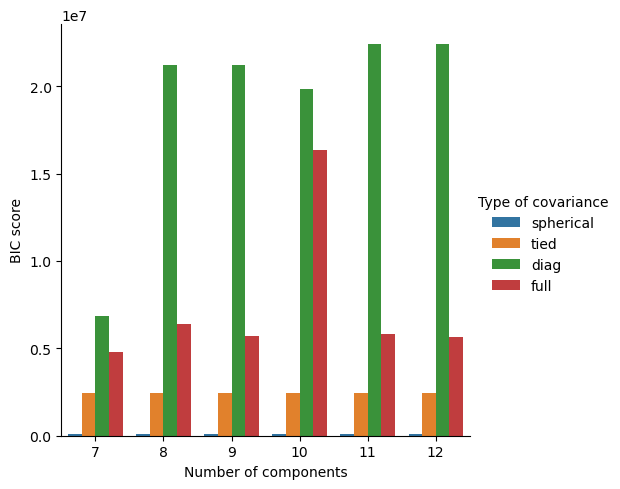

In [13]:
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
);


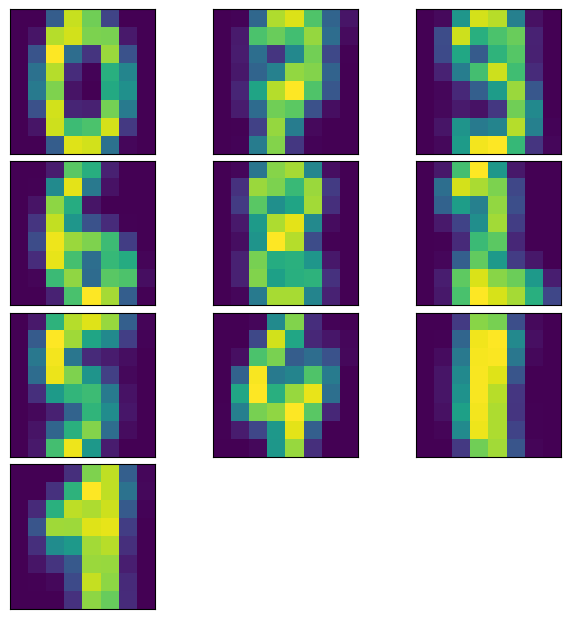

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

cmeans = grid_search.best_estimator_.means_

for i in range(cmeans.shape[0]):
    ax = fig.add_subplot(4, 3, i + 1, xticks=[], yticks=[])
    # data is 28 x 28 pixels, grayscale
    ax.imshow(cmeans[i].reshape(8,8),  interpolation='nearest')
    # label the image with the target value
    #ax.text(0, 7, str(mnist.target.loc[i]))

In [16]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

n_clusters_ = grid_search.best_estimator_.means_.shape[0]
labels = grid_search.predict(data)

print("Estimated number of clusters: %d" % n_clusters_)

print(f"Adjusted Rand Index: {adjusted_rand_score(true_labels, labels):.3f}")
try:
    print(f"Silhouette Coefficient: {silhouette_score(data, labels):.3f}")
except ValueError:
    print('Seems like you only got 1 cluster, so Silhoutte cannot be calculated')

Estimated number of clusters: 10
Adjusted Rand Index: 0.638
Silhouette Coefficient: 0.184


In [62]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline

scgmm = Pipeline([
    ('scaler', QuantileTransformer()),
    ('gmm', GaussianMixture(n_init=5))
])

scparam_grid = {
    "gmm__n_components": range(7, 13),
    "gmm__covariance_type": ["spherical"]#, "tied", "diag", "full"],
}

def scgmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.steps[-1][1].bic(X)

scaled = QuantileTransformer().fit_transform(data)
grid_scaled = GridSearchCV(
    scgmm, param_grid=scparam_grid, scoring=scgmm_bic_score
)
grid_scaled.fit(scaled)

GridSearchCV(estimator=Pipeline(steps=[('scaler', QuantileTransformer()),
                                       ('gmm', GaussianMixture(n_init=5))]),
             param_grid={'gmm__covariance_type': ['spherical'],
                         'gmm__n_components': range(7, 13)},
             scoring=<function scgmm_bic_score at 0x7fe3c9870c10>)

In [63]:
df = pd.DataFrame(grid_scaled.cv_results_)[
    ["param_gmm__n_components", "param_gmm__covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_gmm__n_components": "Number of components",
        "param_gmm__covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
2,9,spherical,5360.225680
3,10,spherical,5467.879288
1,8,spherical,5538.759669
4,11,spherical,5563.891215
5,12,spherical,5701.457791


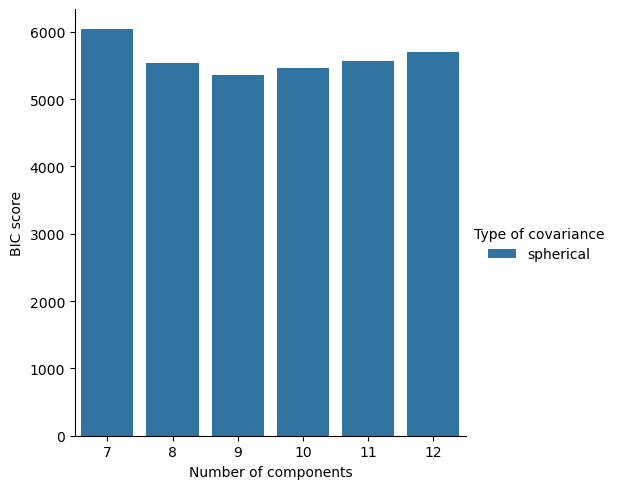

In [64]:
sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
);


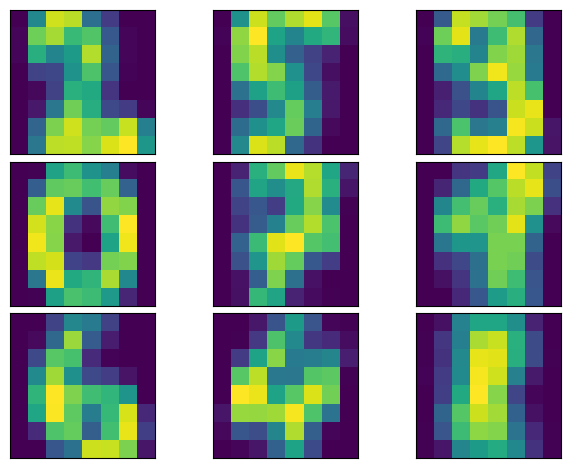

In [65]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

cmeans = grid_scaled.best_estimator_.steps[-1][1].means_

for i in range(cmeans.shape[0]):
    ax = fig.add_subplot(4, 3, i + 1, xticks=[], yticks=[])
    # data is 28 x 28 pixels, grayscale
    ax.imshow(cmeans[i].reshape(8,8),  interpolation='nearest')
    # label the image with the target value
    #ax.text(0, 7, str(mnist.target.loc[i]))

In [66]:
n_clusters_ = grid_scaled.best_estimator_.steps[-1][1].means_.shape[0]
labels = grid_scaled.predict(scaled)

print("Estimated number of clusters: %d" % n_clusters_)

print(f"Adjusted Rand Index: {adjusted_rand_score(true_labels, labels):.3f}")
try:
    print(f"Silhouette Coefficient: {silhouette_score(scaled, labels):.3f}")
except ValueError:
    print('Seems like you only got 1 cluster, so Silhoutte cannot be calculated')

Estimated number of clusters: 9
Adjusted Rand Index: 0.546
Silhouette Coefficient: 0.155
